<a href="https://colab.research.google.com/github/aaccardi/HMC-log/blob/main/Data_generation(Residual_distribution_with_chi_square).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [4]:
import math as math
import sympy as sym
import numpy as np
import random as rdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import constants
from scipy.optimize import curve_fit
from sympy import *
import time


# Constants and Functions


In [6]:
π = np.pi #-- Pi --
inf = np.inf #-- Infinity --
ℯ = np.e #-- Euler's Number --

Integrate = lambda g,lb,ub: np.trapz(g(np.linspace(lb,ub,1000)),np.linspace(lb,ub,1000)) #-- Integration --
Gaussian =  lambda x,a,b,c: a*ℯ**(-0.5*((x-b)/c)**2) #-- Gaussian --
NDist =  lambda x,μ,σ: Gaussian(x,1/(σ*(2*π)**0.5),μ,σ) #-- Normal Distribution --
χ2Dist = lambda x,k: 1/(2**(k/2)*math.gamma(k/2))*x**(k/2-1)*ℯ**(-x/2)#-- X^2 Distribution --

Prob = lambda Func,Bounds: np.array([Integrate(Func,Bounds[i],Bounds[i+1])for i in range(len(Bounds)-1)])
ExpCount = lambda Prob, NDataPoints: Prob*NDataPoints
χ2 = lambda Obs,Exp: np.sum((Obs-Exp)**2/Exp) #-- Chi Squared

# Data generator, Binning and plotting function

In [7]:
#-- Random Number Generation Function --
def NGen(FUNC,RANGE,NDP): 
    XDATA = np.array([]) #-- X-coodinates --
    YDATA = np.array([]) #-- Y-coodinates --
    n = 0 #-- initial number of points --
    while n < NDP : #-- Create randomly generated data set --
        pts = np.round(np.random.rand(2),8) #-- Generate random points, (x,y), rounding increases error *!*obviously*!*--
        if pts[1]*RANGE[1,1] < FUNC(pts[0]*RANGE[0,1]): #-- Accepts points that fall under distribution curve --
            XDATA = np.concatenate((XDATA,[pts[0]*RANGE[0,1]])) #-- x-coordinates -- 
            YDATA = np.concatenate((YDATA,[pts[1]*RANGE[1,1]])) #-- y-coordinates -- 
            n += 1
    return np.array([XDATA,YDATA])


#-- Binning --
def Bin(FUNC, BBOUND, DATA, NDP,NMIN):
    COUNTS = np.array([np.histogram(DATA[i],BBOUND)[0] for i in range(len(DATA))]) #-- Array of Simulated Counts in each bin for each experiment --
    PROBF = Prob(FUNC,BBOUND) #-- Probability of falling into each bin --
    EXPC = ExpCount(PROBF,NDP) #-- Expected counts of each bin --
    NBBOUND = BBOUND[np.insert(EXPC>NMIN,0,True)] #-- New Bin Bounds --
    DX = np.diff(NBBOUND)
    GOODBINS = np.array(range(len(EXPC)))[EXPC>=NMIN] #-- Bins which are rejected --
    GOODNUM = np.array([np.sum(([(DATA[s]>BBOUND[i])&(DATA[s]<BBOUND[i+1]) for i in GOODBINS]),0) for s in range(len(DATA))]) #-- Array of 1's and 0's where 0's are rejected numbers --
    GOODDATA = DATA*GOODNUM #-- All rejected numbers get replaced by 0, all good numbers are kept --
    NXDATA = np.array([np.array([GOODDATA[i][GOODDATA[i]>0][s] for s in range(NDP)]) for i in range(len(DATA))]) #-- Removes all 0's (rejected data) --
    NEXPC = EXPC[EXPC>NMIN]*(NDP/np.sum(EXPC[EXPC>NMIN]))
    NCOUNTS = np.array([(np.histogram(NXDATA[i],BBOUND)[0])[EXPC>NMIN] for i in range(len(DATA))]) #-- Array of Simulated Counts in each bin for each experiment --
    k = len(DX)  #-- Number of bins (must be an integer value)--
    χ2DATA = np.array([χ2(NCOUNTS[i],NEXPC) for i in range(len(NCOUNTS))]) #-- Chi-Squared values of the NGen data --
    return np.array([[k,NBBOUND,NXDATA,COUNTS,NCOUNTS,EXPC,NEXPC,χ2DATA]])



def Plotχ2(χ2DATA,RANGE,DX,k,j,YSTYLE):
    BINS = np.linspace(RANGE[0,0],RANGE[0,1],int(RANGE[0,1]/DX+1)) #-- Chi-Squared Bin Boundaries --
    DoF = k-1 #-- Degrees of Freedom for NGen Data--
    χ2HIST = np.insert(np.histogram(χ2DATA,BINS)[0],0,0)/(j*DX)
    χ2MU = np.mean(χ2DATA) #-- Average Chi-Squared value of the NGen data --
    
    χx = np.linspace(RANGE[0,0],RANGE[0,1],1000)
    
    fig, ax = plt.subplots(figsize = (10,10))#-- Create Plot --
    ax.plot(χx, χ2Dist(χx,DoF), linestyle = '--', c = ([1,0,1]), linewidth = 3, label = 'χ2('+str(DoF)+')') #-- Plot of function χ2(x) with DoF--
    ax.plot(χx, χ2Dist(χx,χ2MU), linestyle = '--', c = ([0,0,1]), linewidth = 3, label = 'χ2('+str(χ2MU)+')') #-- Plot of function χ2(x) with DoF--
    ax.plot(BINS,χ2HIST, drawstyle = 'steps', c = ([0,0,0.5]), linewidth = 3, label = 'bins ='+str(k)); #-- Plot Histogram of χ2Data(x) --

    ax.grid(True)
    ax.axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]])
    ax.set_xlabel('χ2', size = 15)
    ax.set_xticks(np.linspace(RANGE[0,0],RANGE[0,1],11))
    ax.set_xticklabels(np.round(np.linspace(RANGE[0,0],RANGE[0,1],11),2),size = 15)
    ax.set_ylabel('PD(χ2(k))              ', rotation = 0, size = 15)
    ax.set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11))
    ax.set_yticklabels(np.round(np.linspace(RANGE[1,0],RANGE[1,1],11),2),size = 15)
    ax.set_title('χ2 Dist. of '+str(j)+' Experiments with '+str(N)+' Data Points', size = 20)
    ax.legend(fontsize = 20)
    ax.set_yscale(YSTYLE)
    
    return plt.show(ax)

def PlotData(FUNC,FIT,XYDATA,XDATA,COUNTS,BBOUND,RANGE,YSTYLE):
    PFUNC = Prob(FUNC,BBOUND) #-- Probability of falling into each bin --
    NDP = np.sum(COUNTS)
    EXPC = ExpCount(PFUNC,NDP) #-- Expected counts of each bin --
    DX = np.diff(BBOUND)
    μN = np.mean(XDATA) #-- Observed mean of x of the nth experiment --
    σN = np.std(XDATA) #-- Observed standard deviation of x of the nth experiment --
    FHIST = np.insert(PFUNC/DX,0,0) #-- Histogram for Mod(x) for the bb --
    HIST = np.insert(COUNTS/(NDP*DX)*np.sum(PFUNC),0,0) #-- Histogram for xx Data --
    HISTERROR = np.insert(COUNTS**0.5/(NDP*DX)*np.sum(PFUNC),0,0) #-- Histogram for xx Data --
    PFIT = Prob(FIT,BBOUND) #-- Probability of falling into each bin for the Observed (best estimate) function--
    FITHIST = np.insert(PFIT/DX,0,0) #-- Histogram for Ob(x) for the bb --
    
    colors = lambda dp: np.array([(([0,0,0,0.01]) if np.any(XDATA==i) else ([1,0,0])) for i in dp])
    x = np.linspace(RANGE[0,0],RANGE[0,1],1000)
    
    fig, ax = plt.subplots(figsize = (10,10))
    
    ax.scatter(XYDATA[0], XYDATA[1] , c = colors(XYDATA[0])) #-- Scatter plot of accepted points (xx,yy) --

    ax.plot(x, FUNC(x), c = ([1,0,0]), linestyle = '-', linewidth = 3, label = "f(x)") #-- Plot of function f(x) --
    ax.plot(BBOUND,FHIST, drawstyle = 'steps', linestyle = '--', c = ([0.75,0,0]), linewidth = 3, label = "f(x) Hist"); #-- Plot Histogram of Mod(x) --

    ax.plot(x, FIT(x), c = ([0,0.75,0]), linestyle = '-', linewidth = 3, label = "BE(x)") #-- Plot of function b(x) --
    ax.plot(BBOUND,FITHIST, drawstyle = 'steps', linestyle = '--', c = ([0,0.75,0]), linewidth = 2, label = "BE(x) Hist"); #-- Plot Histogram of Mod(x) --


    ax.plot(BBOUND,HIST, drawstyle = 'steps', linestyle = '-', c = ([0,0,1]), linewidth = 2, label = "Data Hist"); #-- Plot Histogram of Data --
    ax.errorbar(BBOUND-0.5*np.insert(DX,0,0),HIST, yerr = HISTERROR , fmt ='.k', capsize = 5, elinewidth = 3) #-- Add ErrorBars to Histogram --
    
    ax.grid(True)
    ax.axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]])
    ax.set_xlabel("x", size = 15)
    ax.set_xticks(np.linspace(RANGE[0,0],RANGE[0,1],10))
    ax.set_xticklabels(np.round(np.linspace(RANGE[0,0],RANGE[0,1],10),2),size = 15)
    ax.set_ylabel("PD     ", rotation = 0, size = 15)
    ax.set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11))
    ax.set_yticklabels(np.round(np.linspace(RANGE[1,0],RANGE[1,1],11),1),size = 15)
    ax.set_title('Model Function Distribution of '+str(np.sum(COUNTS))+' data points in '+str(len(BBOUND)-1)+' bins', size = 20)
    ax.legend(fontsize = 15)
    ax.set_yscale(YSTYLE)
    
    return plt.show(ax)


def PlotDoT(EXPMNT,COUNTS,EXCOUNTS,BBOUND,RANGE):
    COUNTSJ = COUNTS[EXPMNT]
    DOT = (COUNTSJ-EXCOUNTS)/(EXCOUNTS)**(1/2) #-- Data over Theory --
    DOTERR = (COUNTSJ)**(1/2)/(EXCOUNTS)**(1/2) #-- Histogram for x Data --
    
    DX = np.diff(BBOUND)
    fig, ax = plt.subplots(1, len(EXPMNT), sharey = True, figsize = (30,10))
    
    ([ax[i].plot((0,1),(0,0),linewidth = 2) for i in range(len(EXPMNT))]) #-- Plot Histogram of Mod(x) --
    ([ax[i].plot(BBOUND-0.5*DX[1],np.insert(DOT[i],0,0), 'o', c = ([0,0,0.5,1]), linewidth = 15, label = "Res Data - Ex") for i in range(len(EXPMNT))]) #-- Plot Histogram of Mod(x) --
    ([ax[i].errorbar(BBOUND-0.5*DX[1],np.insert(DOT[i],0,0), yerr = np.insert(DOTERR[i],0,0), fmt ='.k', capsize = 5, elinewidth = 3) for i in range(len(EXPMNT))]) #-- Add ErrorBars to Histogram --

    ([ax[i].grid(True) for i in range(len(EXPMNT))])
    ([ax[i].axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]]) for i in range(len(EXPMNT))])
    ([ax[i].set_xticks(BBOUND) for i in range(len(EXPMNT))])
    ([ax[i].set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11)) for i in range(len(EXPMNT))])
    ([ax[i].set_xlabel("x", size = 20) for i in range(len(EXPMNT))])
    ([ax[i].set_title("Experiment "+str(EXPMNT[i])+"", size = 15) for i in range(len(EXPMNT))])
    ax[0].set_ylabel("Res  ", rotation = 0, size = 20)
    fig.suptitle("Residuals of "+str(np.sum(COUNTSJ[0]))+" datapoints in "+str(len(BBOUND)-1)+" bins", size = 25)
    
    return plt.show()

def PlotRes(EXPMNT,COUNTS,EXCOUNTS,BBOUND,RANGE):
    COUNTSJ = COUNTS[EXPMNT]
    RES = (COUNTSJ-EXCOUNTS)/(COUNTSJ)**(1/2) #-- Data over Theory --
    RESERR = (COUNTSJ)**(1/2)/(COUNTSJ)**(1/2) #-- Histogram for x Data --
    
    DX = np.diff(BBOUND)
    fig, ax = plt.subplots(1, len(EXPMNT), sharey = True, figsize = (30,10))
    
    ([ax[i].plot((0,1),(0,0),linewidth = 2) for i in EXPMNT]) #-- Plot Histogram of Mod(x) --
    ([ax[i].plot(BBOUND-0.5*DX[1],np.insert(RES[i],0,0), 'o', c = ([0,0,0.5,1]), linewidth = 15, label = "Res Data - Ex") for i in range(len(EXPMNT))]) #-- Plot Histogram of Mod(x) --
    ([ax[i].errorbar(BBOUND-0.5*DX[1],np.insert(RES[i],0,0), yerr = np.insert(RESERR[i],0,0), fmt ='.k', capsize = 5, elinewidth = 3) for i in range(len(EXPMNT))]) #-- Add ErrorBars to Histogram --

    ([ax[i].grid(True) for i in range(len(EXPMNT))])
    ([ax[i].axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]]) for i in range(len(EXPMNT))])
    ([ax[i].set_xticks(BBOUND) for i in range(len(EXPMNT))])
    ([ax[i].set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11)) for i in range(len(EXPMNT))])
    ([ax[i].set_xlabel("x", size = 20) for i in range(len(EXPMNT))])
    ([ax[i].set_title("Experiment "+str(EXPMNT[i])+"", size = 15) for i in range(len(EXPMNT))])
    ax[0].set_ylabel("Res  ", rotation = 0, size = 20)
    fig.suptitle("Residuals of "+str(np.sum(COUNTSJ[0]))+" datapoints in "+str(len(BBOUND)-1)+" bins", size = 25)

    return plt.show()

def PlotRes2(EXPMNT,COUNTS,EXCOUNTS,FITEXCOUNTS,BBOUND,RANGE):
    COUNTSJ = COUNTS[EXPMNT]
    RES2 = (COUNTS-EXCOUNTS)/((FITEXCOUNTS)**(1/2)) #-- residuals --
    RES2ERR = (COUNTS)**(1/2)/(FITEXCOUNTS)**(1/2) #-- Histogram for xx Data --

    DX = np.diff(BBOUND)
    fig, ax = plt.subplots(1, len(EXPMNT), sharey = True, figsize = (30,10))
    
    ([ax[i].plot((0,1),(0,0),linewidth = 2) for i in EXPMNT]) #-- Plot Histogram of Mod(x) --
    ([ax[i].plot(BBOUND-0.5*DX[1],np.insert(RES2[i],0,0), 'o', c = ([0,0,0.5,1]), linewidth = 15, label = "Res Data - Ex") for i in range(len(EXPMNT))]) #-- Plot Histogram of Mod(x) --
    ([ax[i].errorbar(BBOUND-0.5*DX[1],np.insert(RES2[i],0,0), yerr = np.insert(RES2ERR[i],0,0), fmt ='.k', capsize = 5, elinewidth = 3) for i in range(len(EXPMNT))]) #-- Add ErrorBars to Histogram --

    ([ax[i].grid(True) for i in range(len(EXPMNT))])
    ([ax[i].axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]]) for i in range(len(EXPMNT))])
    ([ax[i].set_xticks(BBOUND) for i in range(len(EXPMNT))])
    ([ax[i].set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11)) for i in range(len(EXPMNT))])
    ([ax[i].set_xlabel("x", size = 20) for i in range(len(EXPMNT))])
    ([ax[i].set_title("Experiment "+str(EXPMNT[i])+"", size = 15) for i in range(len(EXPMNT))])
    ax[0].set_ylabel("Res  ", rotation = 0, size = 20)
    fig.suptitle("Residuals of "+str(np.sum(COUNTSJ[0]))+" datapoints in "+str(len(BBOUND)-1)+" bins", size = 25)

    return plt.show()


def PlotResDist(COUNTS,EXCOUNTS,BBOUND,RANGE):
    x = np.linspace(RANGE[0,0],RANGE[0,1],1000)
    DX = BBOUND[1]-BBOUND[0]
    RES = ((COUNTS-EXCOUNTS)/(EXCOUNTS)**(1/2)).flatten() #-- residuals --
    μRES = np.mean(RES)
    σRES = np.std(RES)
    RESHIST = np.insert(np.histogram(RES,BBOUND)[0],0,0)/(len(RES)*DX) #-- Array of Simulated Counts in each bin for each experiment --
   

    fig, ax = plt.subplots(figsize = (10,10))

    ax.plot(BBOUND,RESHIST, drawstyle = 'steps', linestyle = '-', c = ([0,0,1]), linewidth = 2, label = "Res. Hist"); #-- Plot Histogram of Data --
    ax.plot(x,NDist(x,μRES,σRES), c = ([0,0,1]), linewidth = 3, label = 'Gauss('+str(np.round(μRES,5))+','+str(np.round(σRES,5))+')')
    ax.plot(x,NDist(x,0,1), c = ([1,0,0]), linewidth = 3, linestyle = '--', label = 'Gauss(0,1)')
    #ax.plot(x,NDist(x,μ2,σ2), c = ([0,1,0]), linewidth = 3, label = 'Gauss('+str(np.round(μ2,5))+','+str(np.round(σ2,5))+')')
    ax.grid(True)
    ax.axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]])
    ax.set_xlabel("Residuals", size = 20)
    ax.set_xticks(np.linspace(RANGE[0,0],RANGE[0,1],11))
    ax.set_ylabel("Probability  ", size = 20)
    ax.set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11))
    ax.set_title('Res. Dist. of '+str(len(COUNTS))+' Experiments with '+str(len(COUNTS[0]))+' Bins', size = 20)
    ax.legend(fontsize = 20)
    
    return ([RES,ax])

# Variables

In [8]:
#-- Variables --
xmin = 0
xmax = 1

#-- Parameters --
mϕ = 0.822 #-- GeV, mass of jet --
M = 0.939 #-- GeV, mass of proton --
Λ = 0.609 #-- GeV, confinement paramater  --
g = 1 #-- GeV^2, coupling constant --
mq = 0.3 #-- GeV, mass of quark --


L = lambda x: x*mϕ**2 + (1-x)*Λ**2-x*(1-x)*M**2

#-- Function --
q = lambda x: g**2/(2*π)**2*(2*(mq+x*M)**2+L(x))*(1-x)**3/(24*L(x)**3) #-- model quark PDF, q(x)--
A = 1/Integrate(q,xmin,xmax) #-- Normalizing constant for function q(x) --
f = lambda x: A*q(x) #-- Normalized PDF, q(x) --

x = np.linspace(xmin,xmax,1000) #-- X-coordinates
ymin = 0
ymax = np.max(f(x))
Range = np.array([[xmin,xmax],[ymin,ymax]])

# Generating the data

In [11]:
# Generating the data

N = 1000#-- Number of data points --
J = 500 #-- Number of Experiments --
ndp = 1.1*N #-- Number of data points to generate generated points --

start = time.time()

Data = np.array([NGen(f,Range,ndp) for i in range(J)]) #-- Experimental Data from the NGen Function --
XData = np.array([Data[i,0] for i in range(J)]) #-- Experimental XData from the NGen Function --

end = time.time()
print(end - start)

25.618280172348022


# Binning and Chi square

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2.421548843383789
11


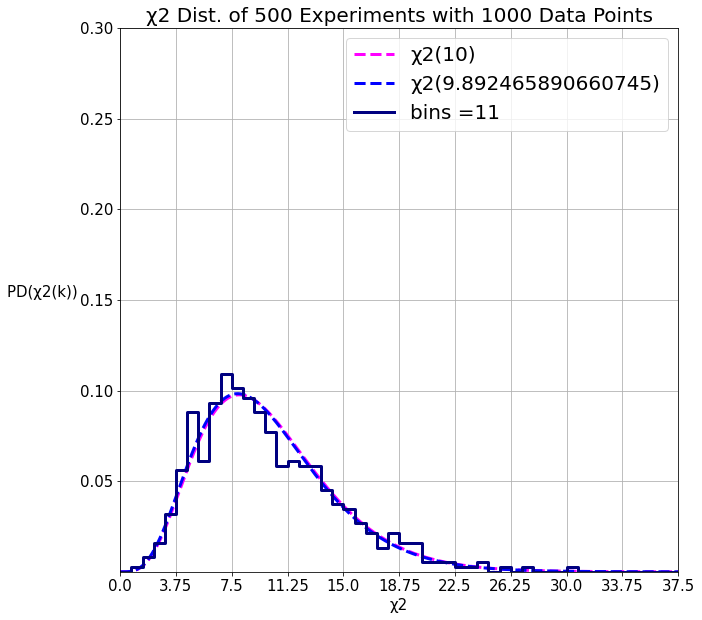

In [12]:
# Binning and chi square

nmin = 5 #-- Minimum amount of data points required to accept the bin --

#-- Binning --
K = 15#-- Number of bins --
bb = np.linspace(0,1,K+1)#-- Create bin boundaries --

start = time.time()

([[NK,nbb,NXData,Counts,NCounts,ExpCounts,NExpCounts,χ2Data]]) = Bin(f,bb,XData,N,nmin) #--Bin the data --

end = time.time()
print(end - start)


print(NK)

#-- Plotting the Chi-Squared Distribution--
χ2Range = np.array([[0,1.25*np.round(np.max(χ2Data))],[0.00001,0.30]]) #-- Chi-Squared Range --
χ2dx = χ2Range[0,1]/50 #-- Chi Squared Bin Width --

Plotχ2(χ2Data,χ2Range,χ2dx,NK,J,'linear')

# Looking at a single Experiement

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


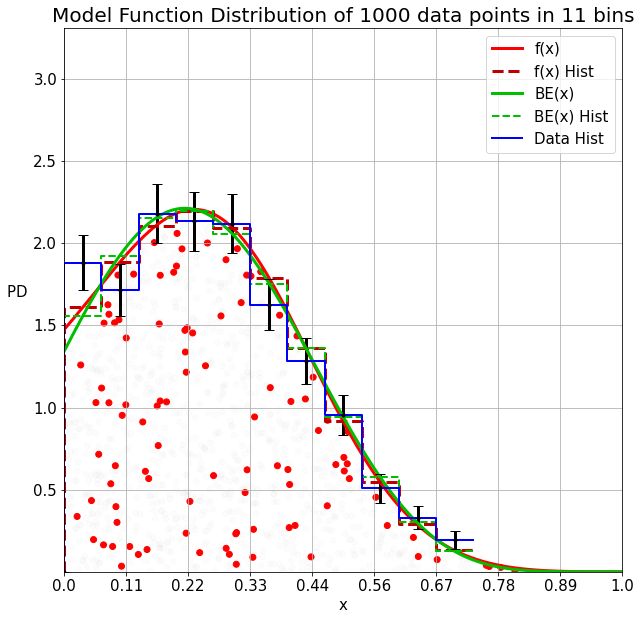

Mean = 0.27
Standard Deviation = 0.16
Counts = [126 115 146 143 142 109  86  64  34  22  13]
Expected Counts = [108. 126. 141. 147. 140. 120.  91.  61.  37.  19.   9.]
Expected Counts = [104. 129. 144. 147. 137. 117.  91.  63.  39.  20.   9.]
χ2 = 8.15
c1= 5.387535863465098
d1= 5.898121894645943
params= (array([3758.75247868,    5.38753586,    5.89812189]), array([[1.62671088e+05, 7.25297000e+01, 6.92458097e+01],
       [7.25297000e+01, 3.28329183e-02, 3.06223376e-02],
       [6.92458097e+01, 3.06223376e-02, 3.00275002e-02]]))
nbb= [0.         0.06666667 0.13333333 0.2        0.26666667 0.33333333
 0.4        0.46666667 0.53333333 0.6        0.66666667 0.73333333]


In [13]:
# Looking at a single experiement

j = 0#--Experiment j--
DPj = Data[j]
XDataj = NXData[j]
Cj = NCounts[j]
Exj = NExpCounts

μj = np.mean(XDataj) #-- Observed mean of x of the jth experiment --
σj = np.std(XDataj) #-- Observed standard deviation of x of the jth experiment --
χ2j = χ2Data[j]  #-- Chi Squared test value of the nth experiment --

LOb=lambda x,b,c,d:((b*(x+0.5)**c)*((1-x))**d)

def fit_func(x,b,c, d): #-- Define the parameters that are being fit --
    return LOb(x,b,c,d) #-- Define the function that is being used to fit --
params = curve_fit(fit_func,np.delete(nbb,0)-0.5*(nbb[1]-nbb[0]),Exj) #-- Fit the curve to the average bin points --
#params = curve_fit(fit_func,np.delete(nbb,0),Exj)
[b1,c1,d1] = params[0] #-- Redifine parameters to desired variables --

Ob = lambda x: LOb(x,b1,c1,d1) #-- Observed PDF, g(x), based on data --
AOb = 1/Integrate(Ob,xmin,xmax) #-- Normalizing constant for function q(x) --
b = lambda x: AOb*Ob(x) #-- Normalized Best Estimate PDF, q(x) --



PObj = Prob(b,nbb) #-- Probability of falling into each bin --
ExObj = ExpCount(PObj,N/np.sum(PObj)) #-- Expected counts of each bin for the best estimate--


Rangej = np.array([[0,1],[10**(-5),1.5*ymax]])

PlotData(f,b,DPj,XDataj,Cj,nbb,Rangej,'linear')

print("Mean =", np.round(μj,2))
print("Standard Deviation =", np.round(σj,2))
print("Counts =", Cj)
print("Expected Counts =", np.round(Exj,0))
print("Expected Counts =", np.round(ExObj,0))
print("χ2 =", np.round(χ2j,2))
print("c1=",c1)
print("d1=",d1)
print("params=",params)
print("nbb=",nbb)

#### Plotting the Data over Theory Ratio centered at 0
The residuals are defined as the ratio between the difference in the expected and observed values by the expected value. That is:
\begin{equation*}
    Res_i = \frac{(O_i-E_i)}{\sqrt{E_i}}
\end{equation*}

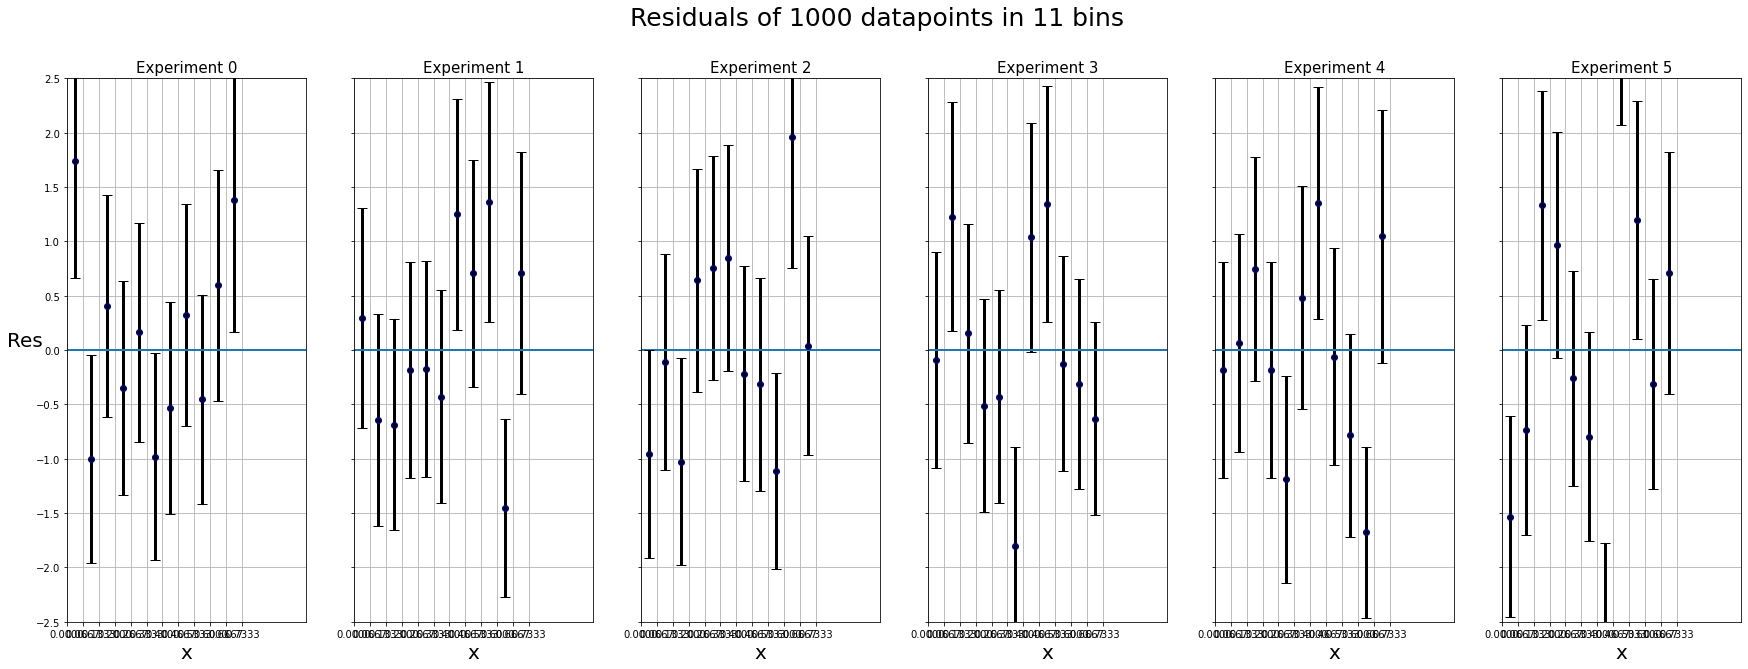

In [14]:
Exprmnts = np.array([0,1,2,3,4,5])

DoTjRange = np.array([[0,1],[-2.5,2.5]])
PlotDoT(Exprmnts,NCounts,NExpCounts,nbb,DoTjRange)

#### Plotting the Residuals with Respect to the Theory
The residuals are defined as the ratio between the difference in the expected and observed values by the expected value. That is:
\begin{equation*}
    Res_i = \frac{(O_i-E_i)}{\sqrt{O_i}}
\end{equation*}

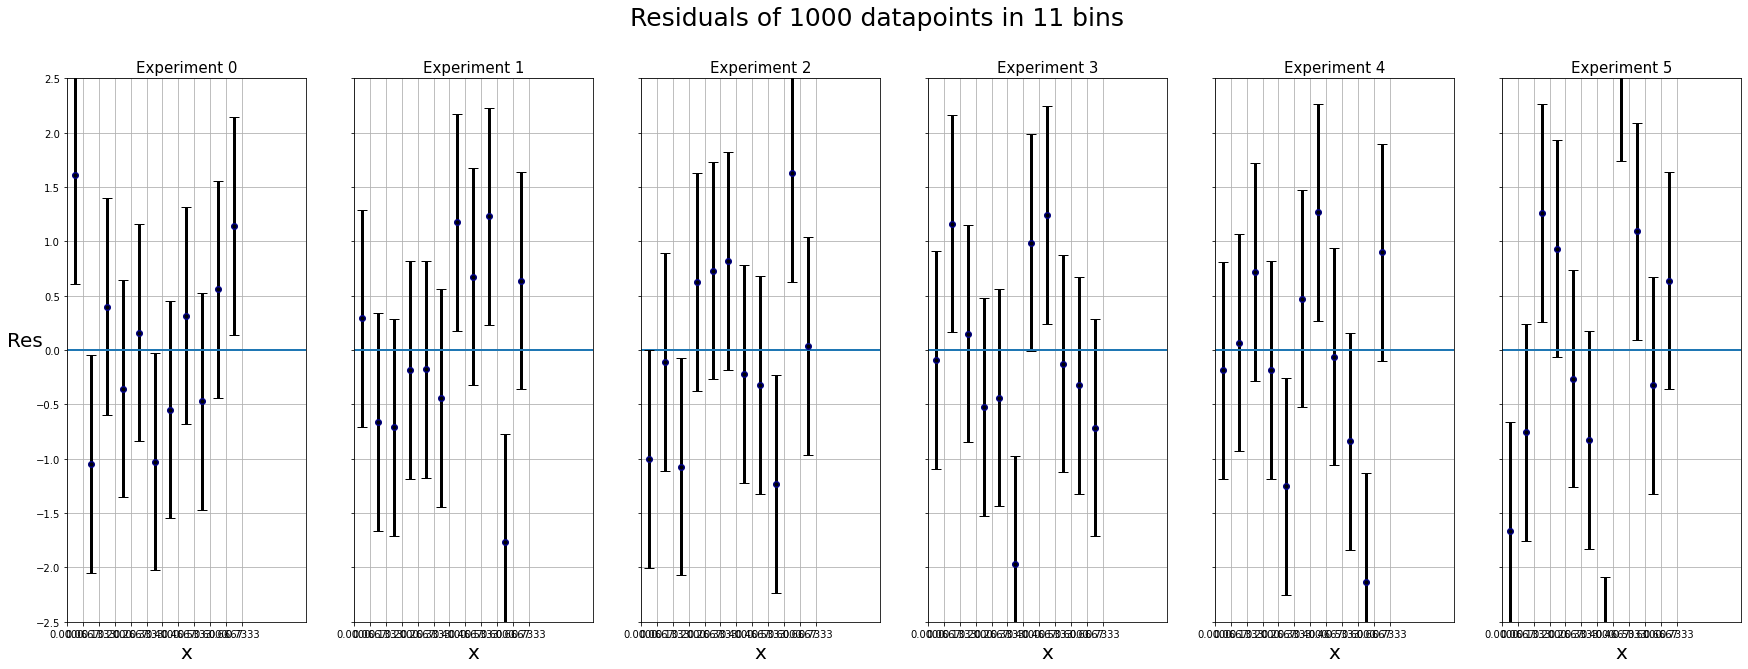

In [15]:
ResjRange = np.array([[0,1],[-2.5,2.5]])
PlotRes(Exprmnts,NCounts,NExpCounts,nbb,DoTjRange)

#### Plotting the Data over Best Estimate Fit Ratio centered at 0
The residuals are defined as the ratio between the difference in the expected and observed values by the best fit value. That is:
\begin{equation*}
    Res_i = \frac{(O_i-B_i)}{\sqrt{B_i}}
\end{equation*}

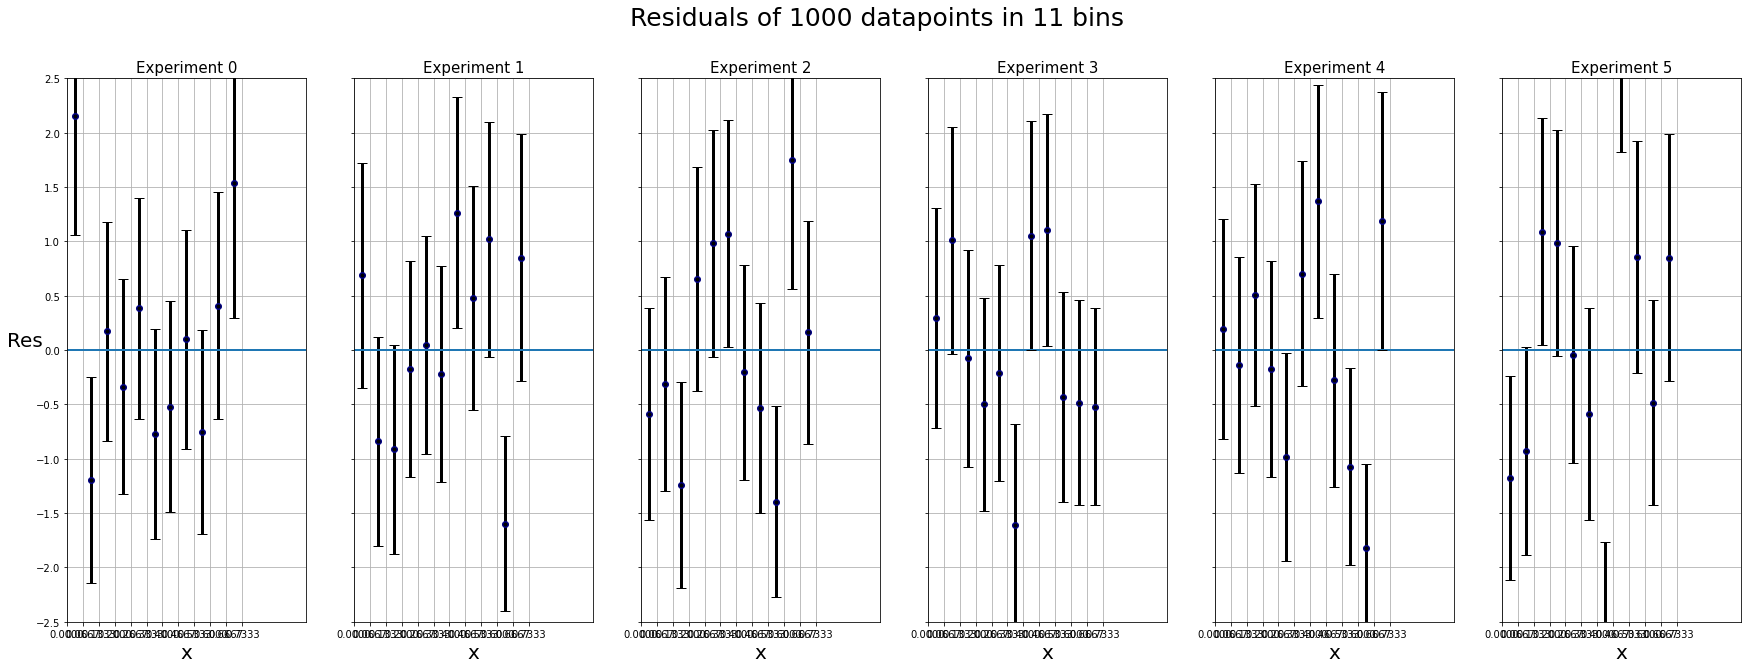

In [16]:
DoTjRange = np.array([[0,1],[-2.5,2.5]])
PlotDoT(Exprmnts,NCounts,ExObj,nbb,DoTjRange)

# Looking at all Experiement

In [17]:
# Looking at all the experiement

xJ = np.array([Data[i,0] for i in range(len(Data))]).flatten()
yJ = np.array([Data[i,1] for i in range(len(Data))]).flatten()
DPJ = np.array([xJ,yJ])
XDataJ = XData.flatten()
CJ = np.array([[sum(Counts)[i] for i in range(K)],[0 for i in range(K)]])
ExJ = ExpCounts*J*ndp/N

μJ = np.mean(XDataJ) #-- Observed mean of x of the nth experiment --
σJ = np.std(XDataJ) #-- Observed standard deviation of x of the nth experiment --

PObJ = Prob(b,bb) #-- Probability of falling into each bin --
ExObJ = ExpCount(PObJ,J*ndp) #-- Expected counts of each bin for the best estimate--

χ2J = χ2(CJ[0],ExJ)  #-- Chi Squared test value of the nth experiment --

print("Mean =", np.round(μJ,2))
print("Standard Deviation =", np.round(σJ,2))
print("Bin Count =", len(CJ[0]))
print("Counts =", CJ[0])
print(np.sum(CJ[0]))
print("Expected Counts =", np.round(ExJ,0))
print(np.sum(ExJ))
print("Expected Counts =", np.round(ExObJ,0))
print(np.sum(ExObJ))
print("χ2 =", np.round(χ2J,2))

Mean = 0.27
Standard Deviation = 0.16
Bin Count = 15
Counts = [58943 69223 77487 80559 76982 65276 49967 33521 19901 10704  4871  1926
   547    90     3]
550000
Expected Counts = [5.9090e+04 6.9112e+04 7.7299e+04 8.0608e+04 7.6693e+04 6.5543e+04
 4.9866e+04 3.3656e+04 2.0122e+04 1.0611e+04 4.8660e+03 1.8720e+03
 5.5500e+02 1.0200e+02 5.0000e+00]
550000.1798022687
Expected Counts = [5.7019e+04 7.0468e+04 7.8907e+04 8.0632e+04 7.5380e+04 6.4358e+04
 4.9869e+04 3.4663e+04 2.1199e+04 1.1058e+04 4.6740e+03 1.4640e+03
 2.8600e+02 2.4000e+01 0.0000e+00]
550000.2996343973
χ2 = 11.42


#### Plotting the Data over Theory 
The residuals are defined as the ratio between the difference in the expected and observed values by the expected value. That is:
\begin{equation*}
    Res_i = \frac{(O_i-E_i)}{E_i}
\end{equation*}

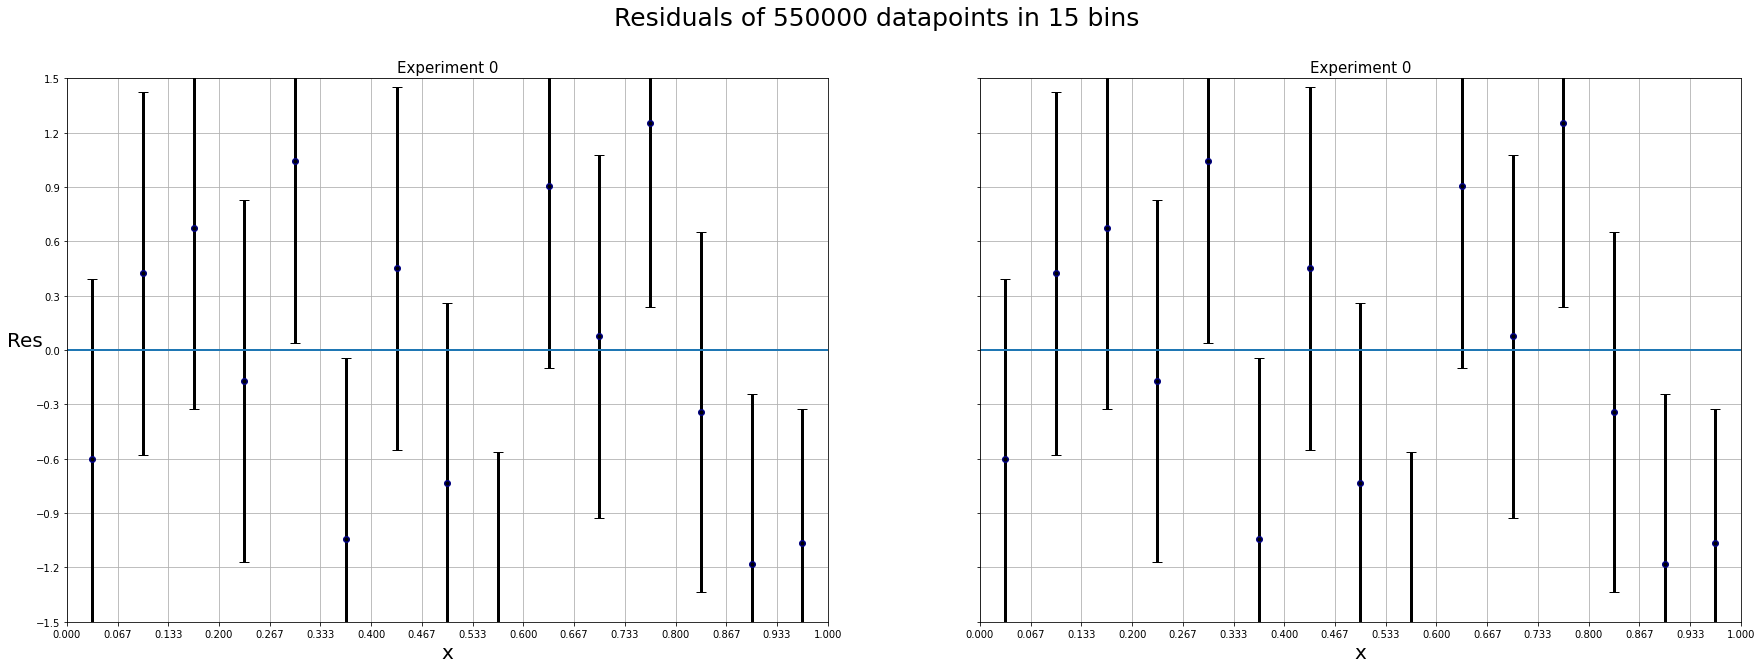

In [18]:
DoTJRange = np.array([[0,1],[-1.5,1.5]])
PlotDoT(np.array([0,0]),CJ,ExJ,bb,DoTJRange)

#### Plotting the Residuals
The residuals are defined as the ratio between the difference in the expected and observed values by the expected value. That is:
\begin{equation*}
    Res_i = \frac{(O_i-E_i)}{\sqrt{O_i}}
\end{equation*}

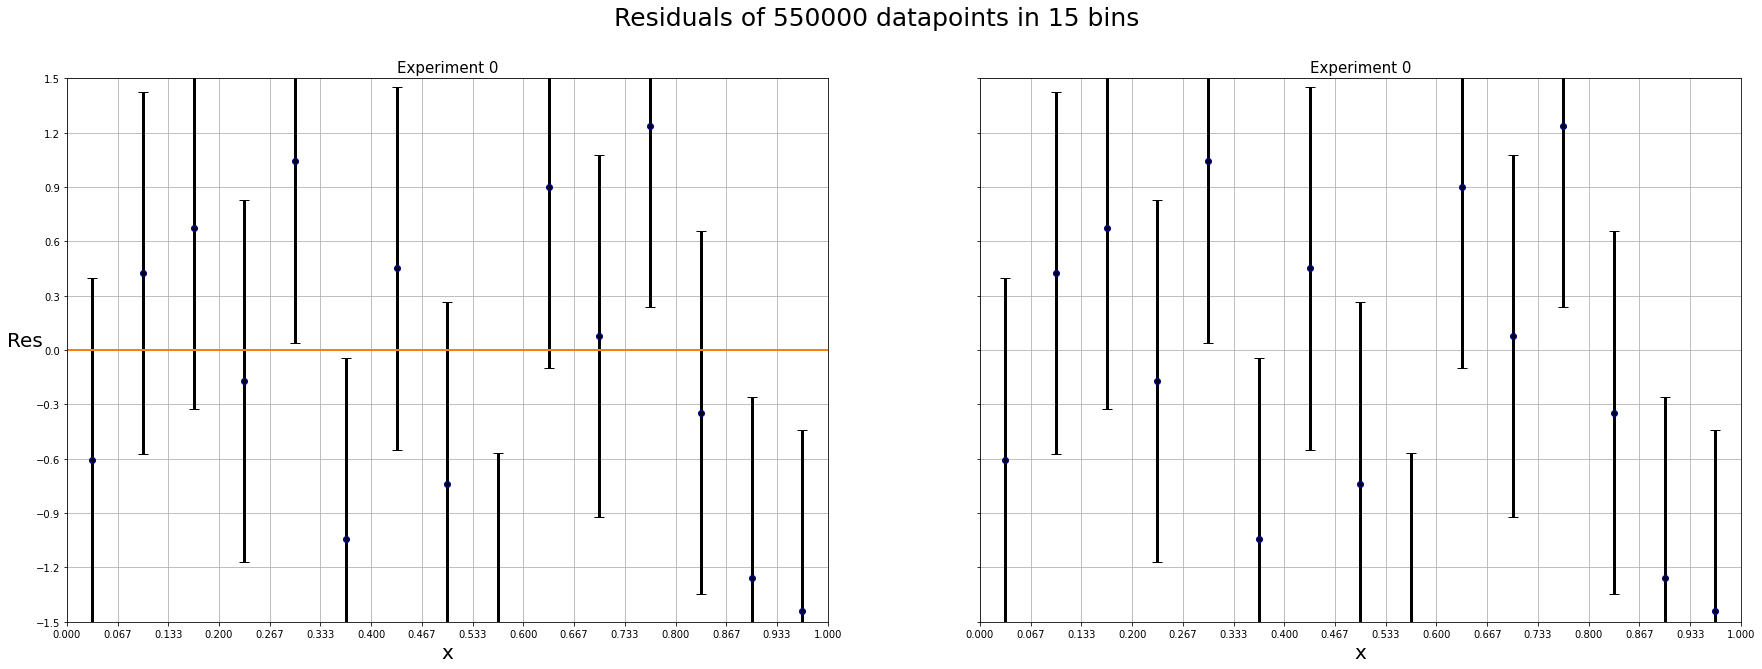

In [19]:
ResJRange = np.array([[0,1],[-1.5,1.5]])
PlotRes(np.array([0,0]),CJ,ExJ,bb,DoTJRange)

# Distribution over the data theory

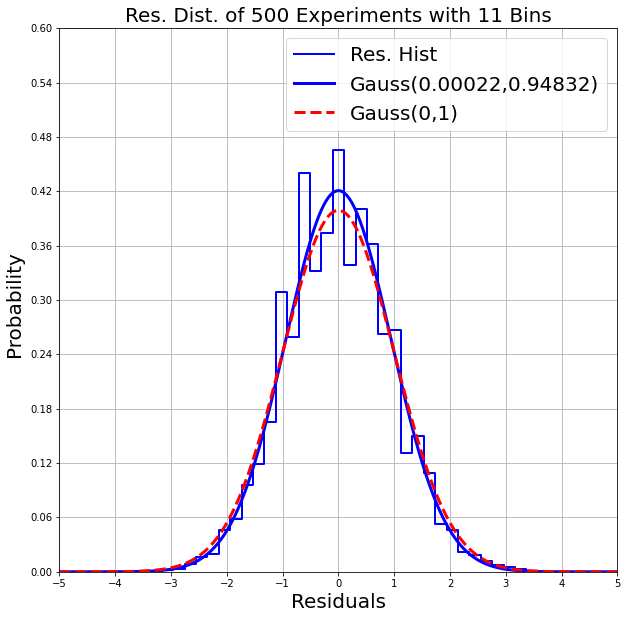

In [20]:
# Distribution over the data theory

ResDisRange = np.array([[-5,5],[0,0.6]])
Resbb = np.linspace(ResDisRange[0,0],ResDisRange[0,1],50)

([res1,ax1]) = PlotResDist(NCounts,Exj,Resbb,ResDisRange)

plt.show(ax1)

# Distribution of Exobserved data

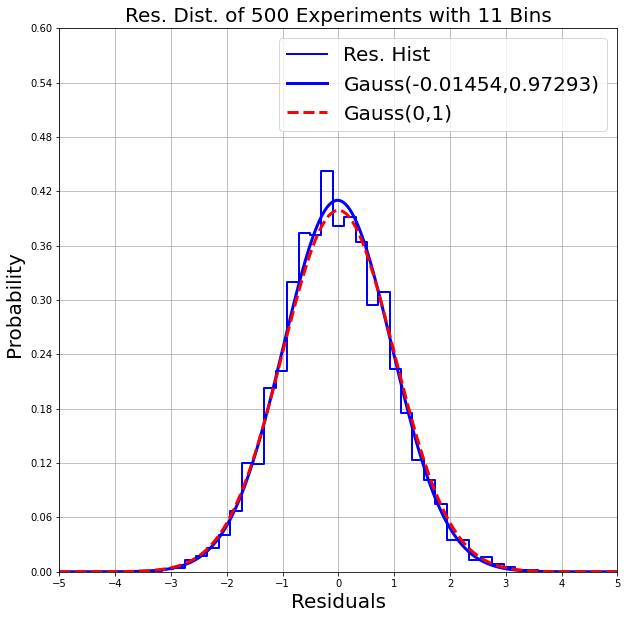

In [21]:
ResDisRange = np.array([[-5,5],[0,0.6]])
Resbb = np.linspace(ResDisRange[0,0],ResDisRange[0,1],50)

([res1,ax1]) = PlotResDist(NCounts,ExObj,Resbb,ResDisRange)

plt.show(ax1)

# Chi square of fitted data

In [22]:
def Plotχ2(χ2FIT,RANGE,DX,K,j,YSTYLE):
    BINS = np.linspace(RANGE[0,0],RANGE[0,1],int(RANGE[0,1]/DX+1)) #-- Chi-Squared Bin Boundaries --
    DoF = K-1 #-- Degrees of Freedom for NGen Data--
    χ2HIST = np.insert(np.histogram(χ2FIT,BINS)[0],0,0)/(j*DX)
    χ2μ = np.mean(χ2FIT) #-- Average Chi-Squared value of the NGen data --
    
    χx = np.linspace(RANGE[0,0],RANGE[0,1],1000)
    
    fig, ax = plt.subplots(figsize = (10,10))#-- Create Plot --
    ax.plot(χx, χ2Dist(χx,DoF), linestyle = '--', c = ([1,0,0]), linewidth = 3, label = 'χ2('+str(DoF)+')') #-- Plot of function χ2(x) with DoF--
    ax.plot(χx, χ2Dist(χx,χ2μ), linestyle = '--', c = ([0,1,0]), linewidth = 3, label = 'χ2('+str(χ2μ)+')') #-- Plot of function χ2(x) with DoF--
    ax.plot(BINS,χ2HIST, drawstyle = 'steps', c = ([0,0,1]), linewidth = 3, label = 'bins ='+str(K)); #-- Plot Histogram of χ2Data(x) --

    ax.grid(True)
    ax.axis([RANGE[0,0],RANGE[0,1],RANGE[1,0],RANGE[1,1]])
    ax.set_xlabel('χ2', size = 15)
    ax.set_xticks(np.linspace(RANGE[0,0],RANGE[0,1],11))
    ax.set_xticklabels(np.round(np.linspace(RANGE[0,0],RANGE[0,1],11),2),size = 15)
    ax.set_ylabel('PD(χ2(k))              ', rotation = 0, size = 15)
    ax.set_yticks(np.linspace(RANGE[1,0],RANGE[1,1],11))
    ax.set_yticklabels(np.round(np.linspace(RANGE[1,0],RANGE[1,1],11),2),size = 15)
    ax.set_title('χ2 Dist. of '+str(j)+' Experiments with '+str(N)+' FITData Points', size = 20)
    ax.legend(fontsize = 20)
    ax.set_yscale(YSTYLE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2.3527779579162598
11


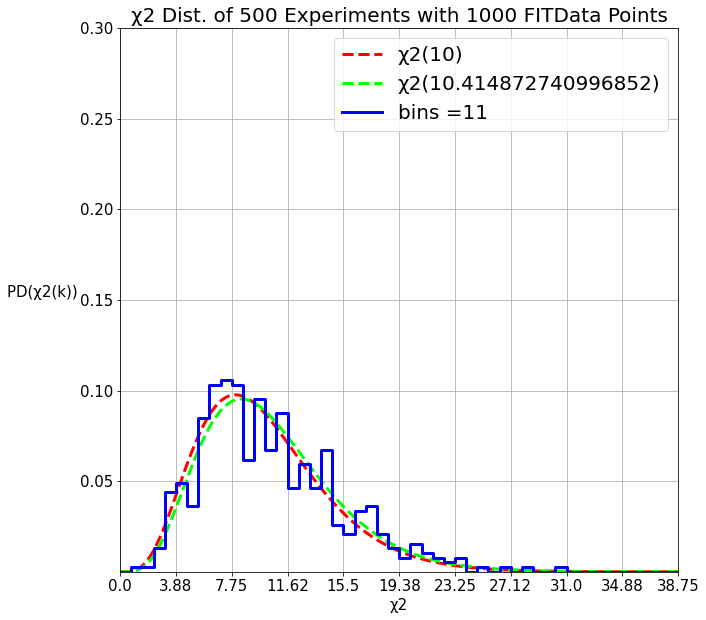

In [23]:
# Chi square for fitted data


# Binning and chi square

Nmin = 5 #-- Minimum amount of data points required to accept the bin --

#-- Binning --
K = 15#-- Number of bins --
BB = np.linspace(0,1,K+1)#-- Create bin boundaries --

start = time.time()

([[NK,nBB,NXFIT,Counts,NCounts,ExpCounts,NExObj,χ2FIT]]) = Bin(b,BB,XData,N,Nmin) #--Bin the data --

end = time.time()
print(end - start)


print(NK)

#-- Plotting the Chi-Squared Distribution--
χ2Range = np.array([[0,1.25*np.round(np.max(χ2FIT))],[0.00001,0.30]]) #-- Chi-Squared Range --
χ2dx = χ2Range[0,1]/50 #-- Chi Squared Bin Width --

Plotχ2(χ2FIT,χ2Range,χ2dx,NK,J,'linear')